# Household Consumption
## In this Jupyter Notebook, we will analyze and forecast household consumption

# 1) Data cleaning and data visualization

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# The code was removed by Watson Studio for sharing.

,Unnamed: 0,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,,
2006-12-16 17:24:00,0,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,1,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,2,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,3,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,4,3.666,0.528,235.680,15.800,0.000,1.000,17.0


## Data cleaning

In [3]:
df_hc.replace('?',np.NaN,inplace=True)
df_hc[['Global_active_power','Global_reactive_power','Voltage','Global_intensity','Sub_metering_1',
       'Sub_metering_2','Sub_metering_3']] = \
df_hc[['Global_active_power','Global_reactive_power','Voltage','Global_intensity','Sub_metering_1',
       'Sub_metering_2','Sub_metering_3']].astype(float)
df_hc.dtypes
df_hc.drop(columns=['Unnamed: 0'],inplace=True)
df_hc['Sub_metering_4'] = df_hc['Global_active_power']*(1000/60)  - \
                         (df_hc['Sub_metering_1'] + df_hc['Sub_metering_2'] + df_hc['Sub_metering_3'])

In [7]:
df_hc_6H = df_hc.asfreq(freq='6H')
df_hc_6H.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
datetime,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266667
2006-12-16 23:24:00,1.198,0.000,241.68,6.6,0.0,0.0,0.0,19.966667
2006-12-17 05:24:00,0.716,0.128,246.23,4.4,0.0,0.0,0.0,11.933333
2006-12-17 11:24:00,3.834,0.254,235.27,16.2,37.0,1.0,17.0,8.900000
2006-12-17 17:24:00,3.390,0.170,232.65,14.6,0.0,0.0,17.0,39.500000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9ddc4d1ba8>,
      dtype=object)

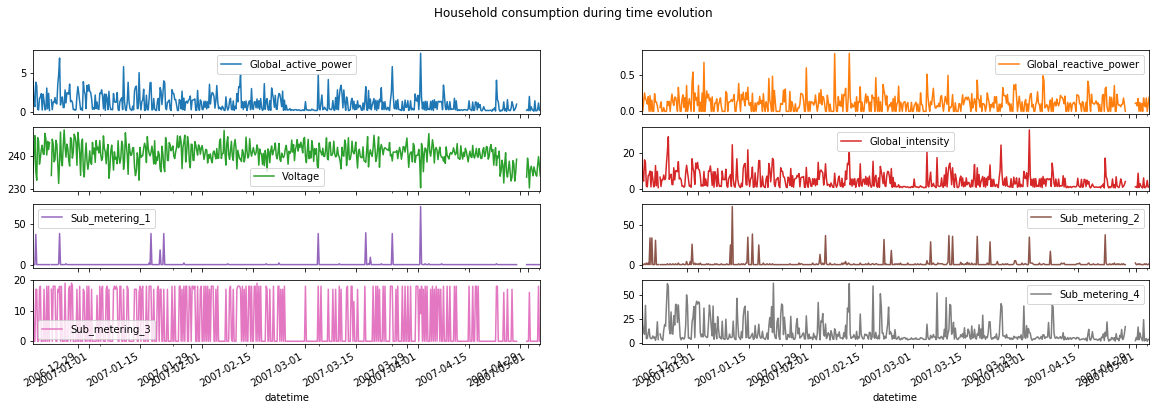

In [8]:
df_hc_6H.plot(subplots=True,layout=(4,2),title='Household consumption during time evolution',figsize=(20, 6))

# Forcasting of the consumption in each room according to the global consumption

## Correlation analysis

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


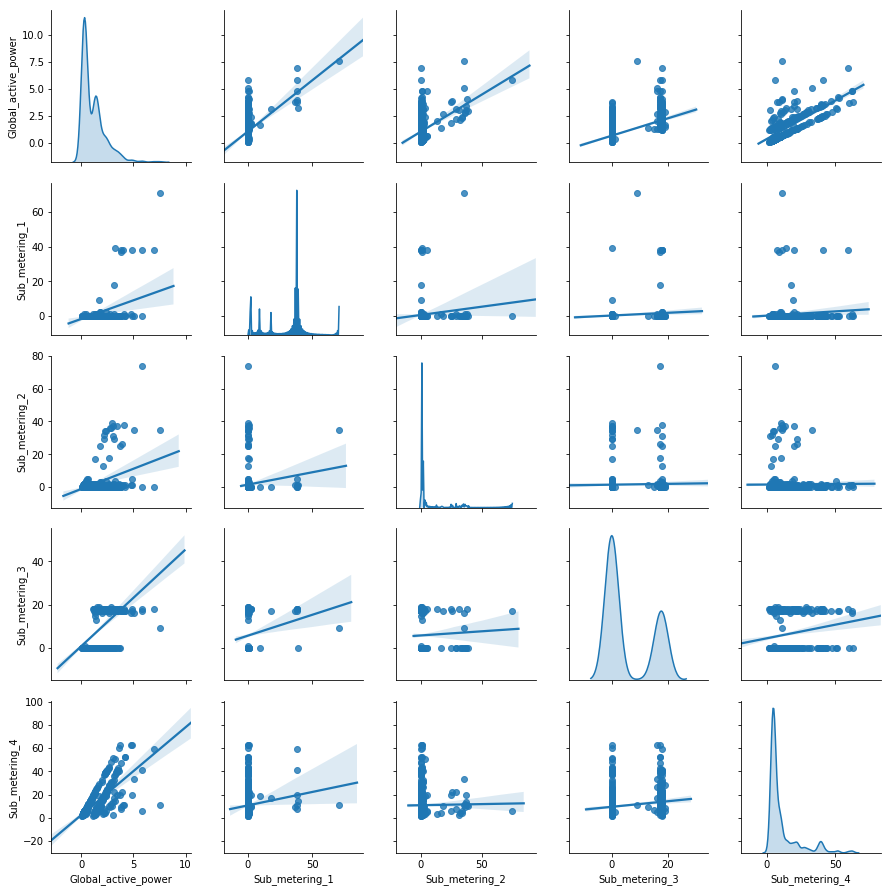

In [6]:
sns.pairplot(df_hc.asfreq(freq='6H').drop(columns=['Global_reactive_power','Voltage','Global_intensity']),
                                     kind="reg",diag_kind="kde")

Text(0.5, 1.0, 'Pearson Correlation Matrix')

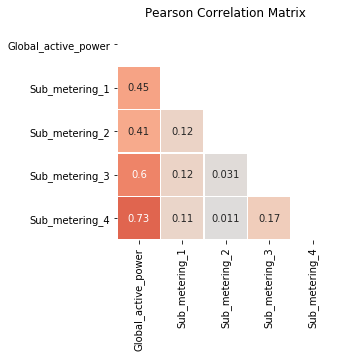

In [11]:
# Compute the correlation matrix
corr = df_hc.asfreq(freq='6H').drop(columns=['Global_reactive_power','Voltage','Global_intensity']).corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots()

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

ax = plt.axes()
sns.heatmap(corr, cmap='coolwarm', mask=mask, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar=False,annot=True,ax=ax)
ax.set_title('Pearson Correlation Matrix')


## Choosing the sample method and coefficient

Optimal sample frequency is  1730 hours with " sum " sampling method
Correlation are [0.63622872 0.55748396 0.77530189 0.93727517]


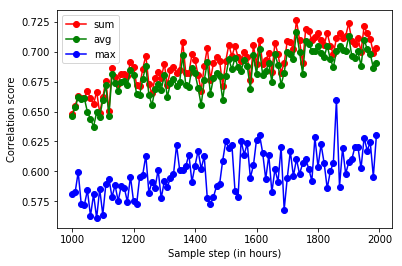

In [13]:
sample_freq_range = range(1000,2000,10)
corr_scores_sum = []
corr_scores_mean = []
corr_scores_max = []
for sample_freq in sample_freq_range:
    corr_sum = np.abs(df_hc.drop(columns=['Global_reactive_power','Voltage','Global_intensity']) \
                        .fillna(method='backfill').resample(str(sample_freq)+'T').sum().corr().values[1:,0]).sum()/4
    
    corr_mean = np.abs(df_hc.drop(columns=['Global_reactive_power','Voltage','Global_intensity']) \
                        .fillna(method='backfill').resample(str(sample_freq)+'T').mean().corr().values[1:,0]).sum()/4
    
    corr_max = np.abs(df_hc.drop(columns=['Global_reactive_power','Voltage','Global_intensity']) \
                        .fillna(method='backfill').resample(str(sample_freq)+'T').max().corr().values[1:,0]).sum()/4
    
    corr_scores_sum.append(corr_sum)
    corr_scores_mean.append(corr_mean)
    corr_scores_max.append(corr_max)

Method = ['sum','avg','max']
    
plt.plot(sample_freq_range,corr_scores_sum,'-o',color='r',label='sum')
plt.plot(sample_freq_range,corr_scores_mean,'-o',color='g',label='avg')
plt.plot(sample_freq_range,corr_scores_max,'-o',color='b',label='max')
plt.xlabel('Sample step (in hours)')
plt.ylabel('Correlation score')
plt.legend()
print('Optimal sample frequency is ',sample_freq_range[np.argmax(corr_scores_sum)],'hours with'
      ,'"',Method[np.argmax([max(corr_scores_sum),max(corr_scores_mean),max(corr_scores_max)])],'"',
      'sampling method')
print('Correlation are',df_hc.drop(columns=['Global_reactive_power','Voltage','Global_intensity']) \
                        .fillna(method='backfill').resample(str(sample_freq_range[np.argmax(corr_scores_sum)])+'T').sum().corr().values[1:,0])

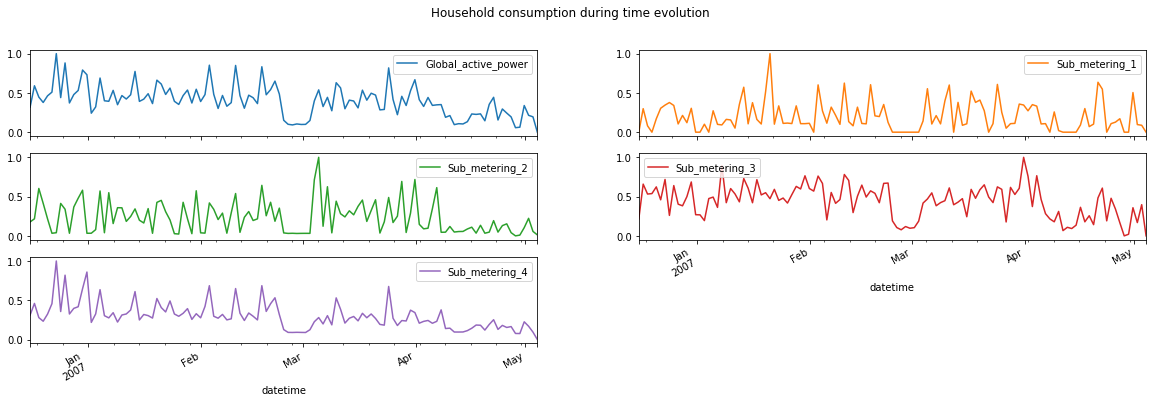

In [14]:
from sklearn import preprocessing

x = df_hc.drop(columns=['Global_reactive_power','Voltage','Global_intensity']) \
                        .fillna(method='backfill').resample(str(sample_freq_range[np.argmax(corr_scores_sum)])+'T').sum().values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_hc_scaled = pd.DataFrame(x_scaled,columns=['Global_active_power','Sub_metering_1',
       'Sub_metering_2','Sub_metering_3','Sub_metering_4'], index=df_hc.drop(columns=['Global_reactive_power','Voltage','Global_intensity']) \
                        .fillna(method='backfill').resample(str(sample_freq_range[np.argmax(corr_scores_sum)])+'T').sum().index)
df_hc_scaled.plot(subplots=True,layout=(3,2),title='Household consumption during time evolution',figsize=(20, 6))

X = df_hc_scaled['Global_active_power'].values.reshape(-1, 1)
y = df_hc_scaled[['Sub_metering_1',
       'Sub_metering_2','Sub_metering_3','Sub_metering_4']].values

## Linear Regression

MSE for Linear Regression : 0.031153881429483585


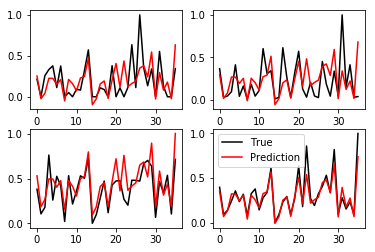

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

clf = LinearRegression().fit(X_train, y_train)
yhat = clf.predict(X_test)
mse_lr = mean_squared_error(y_test, yhat)
print('MSE for Linear Regression :',mse_lr)

plt.subplot(2,2,1)
plt.plot(y_test[:,0],'-',color='k',label='True')
plt.plot(yhat[:,0],'-',color='r',label='Prediction')
plt.subplot(2,2,2)
plt.plot(y_test[:,1],'-',color='k',label='True')
plt.plot(yhat[:,1],'-',color='r',label='Prediction')
plt.subplot(2,2,3)
plt.plot(y_test[:,2],'-',color='k',label='True')
plt.plot(yhat[:,2],'-',color='r',label='Prediction')
plt.subplot(2,2,4)
plt.plot(y_test[:,3],'-',color='k',label='True')
plt.plot(yhat[:,3],'-',color='r',label='Prediction')
plt.legend()

## Support Vector Machine

SVR(C=4.11, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
MSE for SVM Regression : 0.028961086290868066


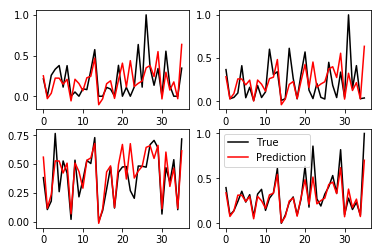

In [30]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
import warnings
warnings.filterwarnings("ignore")

parameters = {'kernel':('linear','rbf','poly','sigmoid'), 'C': np.arange(0.01,10,0.1)}
svr = SVR(gamma='auto')
clf = GridSearchCV(svr, parameters,cv=4)
clf.fit(X_train, y_train[:,2])
print(clf.best_estimator_)

msvr = MultiOutputRegressor(clf)
msvr.fit(X_train, y_train)

yhat = msvr.predict(X_test)
mse_svr = mean_squared_error(y_test, yhat)
print('MSE for SVM Regression :',mse_svr)

plt.subplot(2,2,1)
plt.plot(y_test[:,0],'-',color='k',label='True')
plt.plot(yhat[:,0],'-',color='r',label='Prediction')
plt.subplot(2,2,2)
plt.plot(y_test[:,1],'-',color='k',label='True')
plt.plot(yhat[:,1],'-',color='r',label='Prediction')
plt.subplot(2,2,3)
plt.plot(y_test[:,2],'-',color='k',label='True')
plt.plot(yhat[:,2],'-',color='r',label='Prediction')
plt.subplot(2,2,4)
plt.plot(y_test[:,3],'-',color='k',label='True')
plt.plot(yhat[:,3],'-',color='r',label='Prediction')
plt.legend()

## Decision Tree

DecisionTreeRegressor(criterion='mae', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')
MSE for SVM Regression : 0.02876915246784332


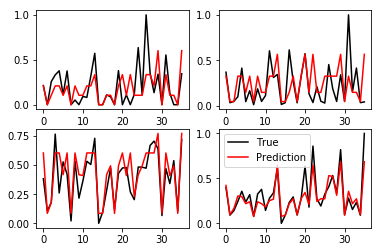

In [18]:
from sklearn.tree import DecisionTreeRegressor

parameters = {'criterion':('mse', 'friedman_mse','mae'), 'max_depth':range(1,15)}
dt = DecisionTreeRegressor(random_state=0)
clf = GridSearchCV(dt, parameters,cv=4)
clf.fit(X_train, y_train[:,2])
print(clf.best_estimator_)

mdt = MultiOutputRegressor(clf)
mdt.fit(X_train, y_train)

yhat = mdt.predict(X_test)
mse_dt = mean_squared_error(y_test, yhat)
print('MSE for SVM Regression :',mse_dt)

plt.subplot(2,2,1)
plt.plot(y_test[:,0],'-',color='k',label='True')
plt.plot(yhat[:,0],'-',color='r',label='Prediction')
plt.subplot(2,2,2)
plt.plot(y_test[:,1],'-',color='k',label='True')
plt.plot(yhat[:,1],'-',color='r',label='Prediction')
plt.subplot(2,2,3)
plt.plot(y_test[:,2],'-',color='k',label='True')
plt.plot(yhat[:,2],'-',color='r',label='Prediction')
plt.subplot(2,2,4)
plt.plot(y_test[:,3],'-',color='k',label='True')
plt.plot(yhat[:,3],'-',color='r',label='Prediction')
plt.legend()

## Neural Network

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=11, learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=1200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='lbfgs', tol=1e-12,
       validation_fraction=0.1, verbose=0, warm_start=False)
MSE for SVM Regression : 0.027569691037951212


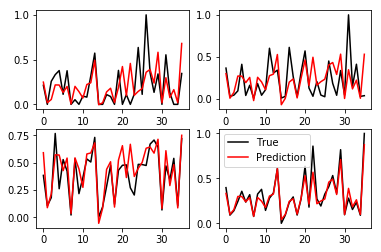

In [23]:
from sklearn.neural_network import MLPRegressor

seed = 0
    
parameters = {'hidden_layer_sizes': range(1,20)}
ANN = MLPRegressor(solver="lbfgs",activation='relu',tol=1e-12,max_iter=1200
                    ,learning_rate = "adaptive",verbose=0)
clf = GridSearchCV(ANN, parameters,cv=4)
clf.fit(X_train, y_train[:,2])
print(clf.best_estimator_)

mANN = MultiOutputRegressor(clf)
mANN.fit(X_train, y_train)

yhat = mANN.predict(X_test)
mse_ANN = mean_squared_error(y_test, yhat)
print('MSE for SVM Regression :',mse_ANN)

plt.subplot(2,2,1)
plt.plot(y_test[:,0],'-',color='k',label='True')
plt.plot(yhat[:,0],'-',color='r',label='Prediction')
plt.subplot(2,2,2)
plt.plot(y_test[:,1],'-',color='k',label='True')
plt.plot(yhat[:,1],'-',color='r',label='Prediction')
plt.subplot(2,2,3)
plt.plot(y_test[:,2],'-',color='k',label='True')
plt.plot(yhat[:,2],'-',color='r',label='Prediction')
plt.subplot(2,2,4)
plt.plot(y_test[:,3],'-',color='k',label='True')
plt.plot(yhat[:,3],'-',color='r',label='Prediction')
plt.legend()

## Summary

In [31]:
t = {'Linear Regression':round(mse_lr,5),'SVM Regression':round(mse_svr,5),'Decision Tree Regression':round(mse_dt,5),'Neural Network':round(mse_ANN,5)}
df = pd.Series(t)
df.sort_values()

Neural Network              0.02757
Decision Tree Regression    0.02877
SVM Regression              0.02896
Linear Regression           0.03115
dtype: float64

# Global active power forecasting

## Is Voltage a the time serie stationnary ?
### We compute the rolling mean and the p-value using the Augmented Dickey-Fuller test, in order to reject or not the non-stationnary hypothesis

ADF Statistic: -2.767181
p-value: 0.063117
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


Text(0.5, 1.0, 'Rolling Standard Deviation')

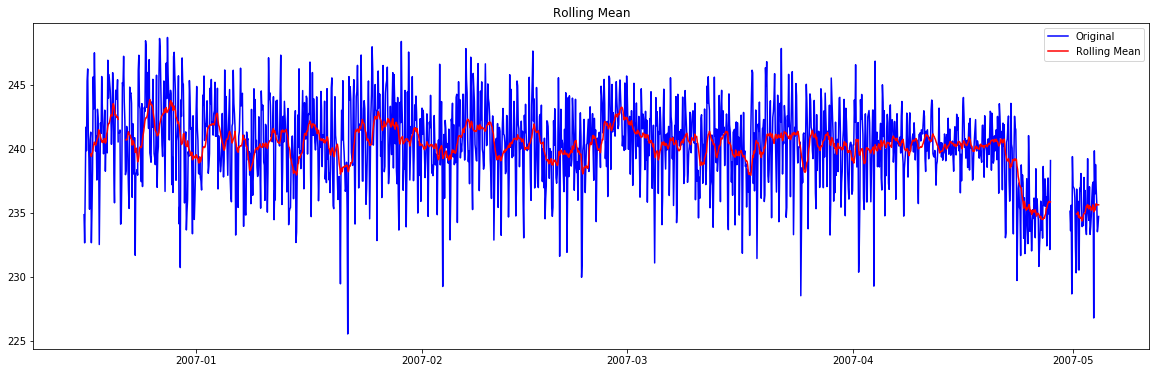

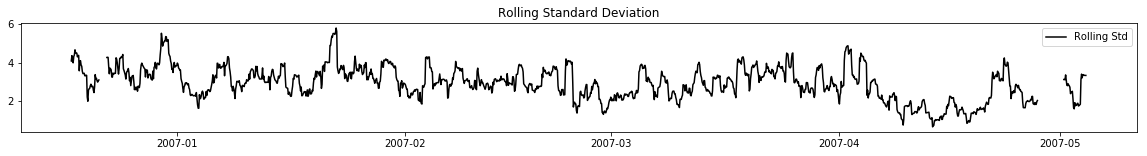

In [38]:
from statsmodels.tsa.stattools import adfuller

series = df_hc['Voltage'].asfreq(freq='2H')

window = 12

rolling_mean = series.rolling(window = window).mean()
rolling_std = series.rolling(window = window).std()

plt.figure(figsize=(20, 6))
plt.plot(series, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.legend(loc = 'best')
plt.title('Rolling Mean')

result = adfuller(series[~series.isnull()])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
plt.figure(figsize=(20, 2))
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Standard Deviation')

### Doing the same with log and shift transformation, we find

ADF Statistic: -11.542672
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


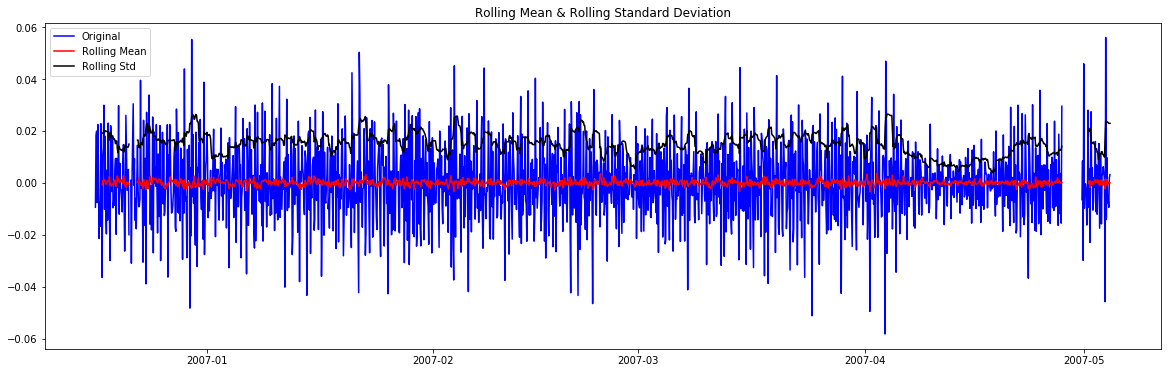

In [39]:
series_log = np.log(series)

series_log_shift = series_log - series_log.shift()

rolling_mean = series_log_shift.rolling(window = window).mean()
rolling_std = series_log_shift.rolling(window = window).std()

plt.figure(figsize=(20, 6))
plt.plot(series_log_shift, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')

result = adfuller(series_log_shift[~series_log_shift.isnull()])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

The p-value is less than **0.05** and tge ADF statistic is negative, then we can conclude that the time serie is stationnary

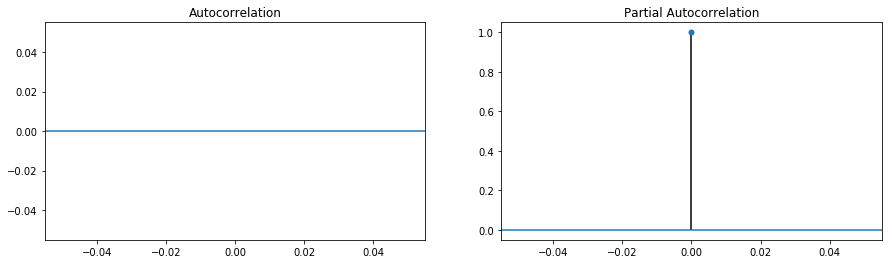

In [40]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# Graph data
fig, axes = plt.subplots(1, 2, figsize=(15,4))

fig = plot_acf(series, lags=40, ax=axes[0])
fig = plot_pacf(series, lags=40, ax=axes[1])

In [41]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(series.fillna(method='backfill'), order=(2, 1, 1))

In [42]:
results = model.fit(disp=-1)

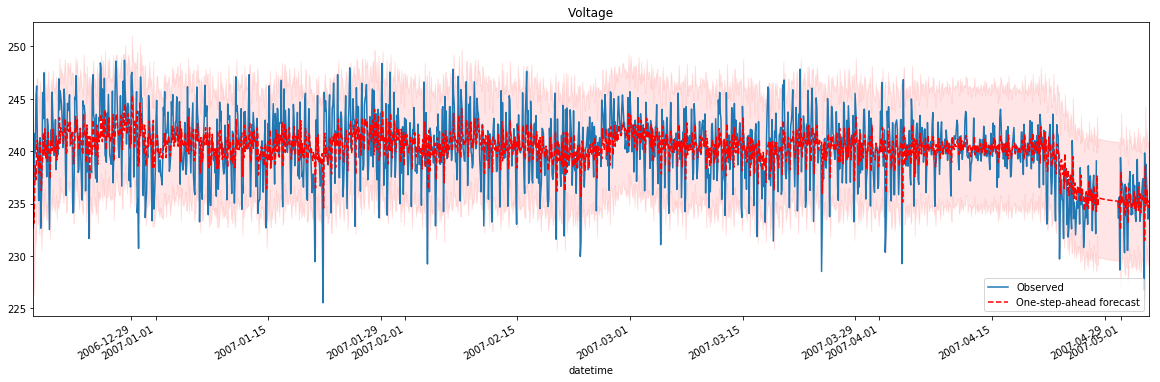

In [48]:
predict = results.get_prediction()
predict_ci = predict.conf_int()

fig, ax = plt.subplots(figsize=(20,6))
npre = 2
ax.set(title='Voltage', xlabel='Date')

# Plot data points
series[1:].plot(ax=ax, style='-', label='Observed')

# Plot predictions
predict.predicted_mean[1:].plot(ax=ax, style='r--', label='One-step-ahead forecast')
ci = predict_ci.iloc[1:]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)


legend = ax.legend(loc='lower right')

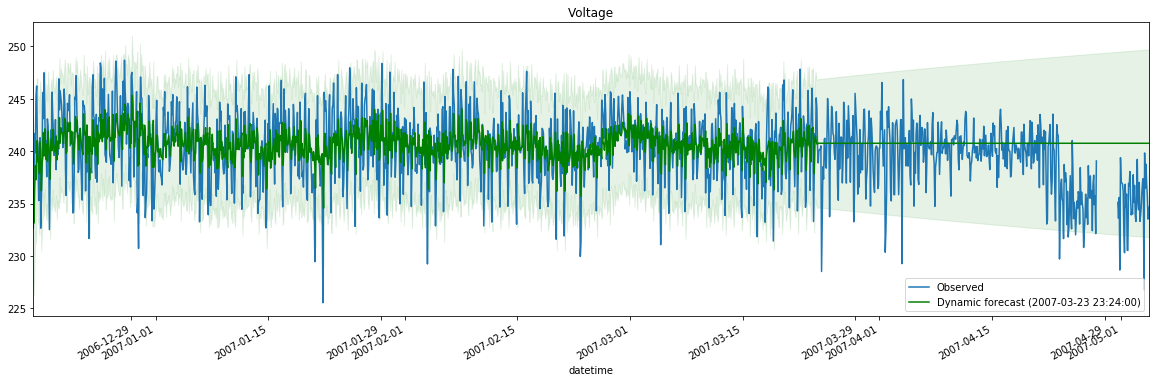

In [49]:
# Dynamic predictions
predict_dy = results.get_prediction(dynamic=str(series.index[len(series)-500]),full_results=True)
predict_dy_ci = predict_dy.conf_int()

fig, ax = plt.subplots(figsize=(20,6))
npre = 2
ax.set(title='Voltage', xlabel='Date')

# Plot data points
series[1:].plot(ax=ax, style='-', label='Observed')

predict_dy.predicted_mean.iloc[1:].plot(ax=ax, style='g', label='Dynamic forecast ('+str(series.index[len(series)-500])+')')
ci = predict_dy_ci.iloc[1:]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.1)

legend = ax.legend(loc='lower right')

# Anomalous datetime detection

## Anomaly dectection using DBSCAN

We analyze 6542 datetimes


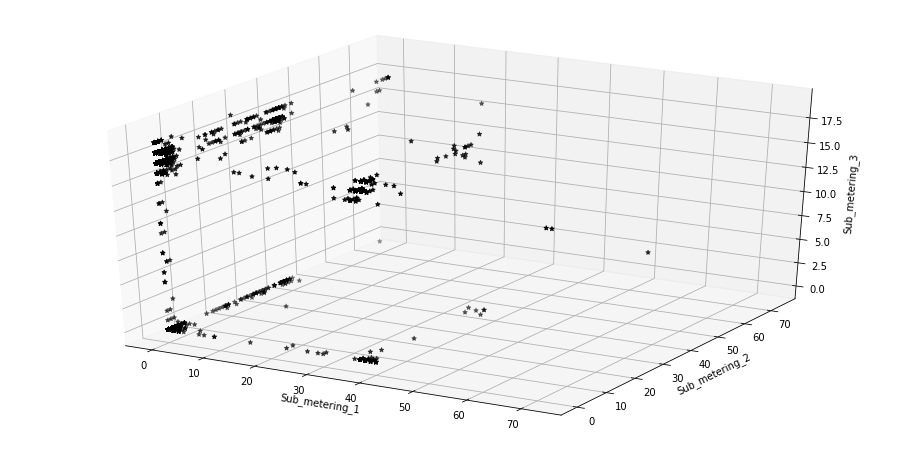

In [57]:
from mpl_toolkits.mplot3d import Axes3D 

df_hc_freq = df_hc.asfreq(freq='30T')
df_hc_skipna = df_hc_freq[(~df_hc_freq['Sub_metering_1'].isnull()) & (~df_hc_freq['Sub_metering_2'].isnull()) & (~df_hc_freq['Sub_metering_2'].isnull())]  \
[['Sub_metering_1','Sub_metering_2','Sub_metering_3']]

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111, projection='3d',)

ax.scatter(df_hc_skipna['Sub_metering_1'],df_hc_skipna['Sub_metering_2'],df_hc_skipna['Sub_metering_3'],c='k', marker='*')
ax.set_xlabel('Sub_metering_1')
ax.set_ylabel('Sub_metering_2')
ax.set_zlabel('Sub_metering_3')

print('We analyze',df_hc_skipna.shape[0],'datetimes')

In [53]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

X = df_hc_skipna[['Sub_metering_1','Sub_metering_2','Sub_metering_3']].values
X = StandardScaler().fit_transform(X)

outlier_detection = DBSCAN(
  eps = 0.5,
  metric="euclidean",
  min_samples = 3,
  n_jobs = -1)
clusters = outlier_detection.fit_predict(X)

Text(0.5, 0, 'Sub_metering_3')

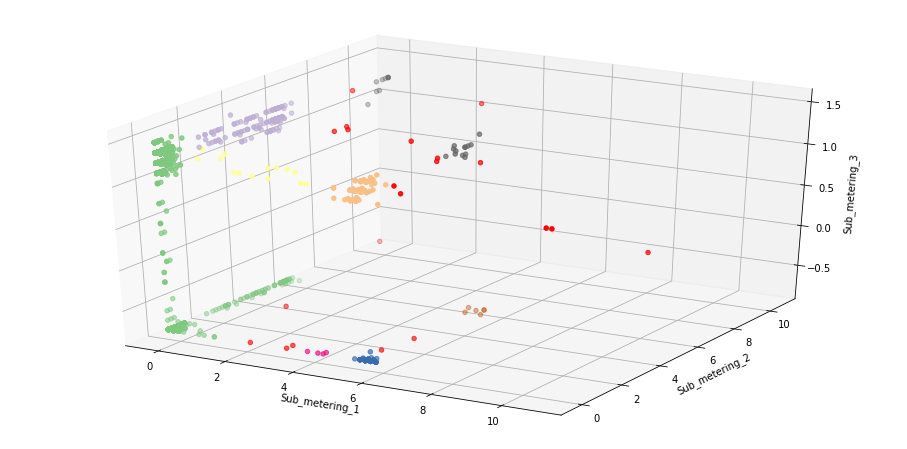

In [54]:
from matplotlib import cm

cmap = cm.get_cmap('Accent')

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
  xs = X[clusters>-1,0],
  ys = X[clusters>-1,1],
  zs = X[clusters>-1,2],
  c = clusters[clusters>-1],
  cmap = cmap,
)

ax.scatter(
  xs = X[clusters<0,0],
  ys = X[clusters<0,1],
  zs = X[clusters<0,2],
  c = 'r'
 # c = clusters,
#  cmap = cmap,
)
ax.set_xlabel('Sub_metering_1')
ax.set_ylabel('Sub_metering_2')
ax.set_zlabel('Sub_metering_3')

In [56]:
clusters_dbscan = clusters
print('There is',round(100*(np.sum(clusters==-1)/df_hc_skipna.shape[0]),1),'% of anomalous datetime, which are')
pd.DataFrame(df_hc_skipna.index[clusters==-1]).rename(columns={'datetime':'Anomaly date-time'})

There is 0.3 % of anomalous datetime, which are


,Anomaly date-time
0,2006-12-19 08:54:00
1,2006-12-25 21:54:00
2,2006-12-29 21:24:00
3,2007-01-13 22:54:00
4,2007-01-17 10:24:00
5,2007-01-20 10:24:00
6,2007-01-21 15:24:00
7,2007-01-21 20:54:00
8,2007-01-21 21:24:00
9,2007-01-21 21:54:00


## Anomaly detection using Isolation Forest

In [58]:
from sklearn.ensemble import IsolationForest

outlier_detection = IsolationForest(random_state=0,n_jobs=-1)
clusters = outlier_detection.fit_predict(X)

Text(0.5, 0, 'Sub_metering_3')

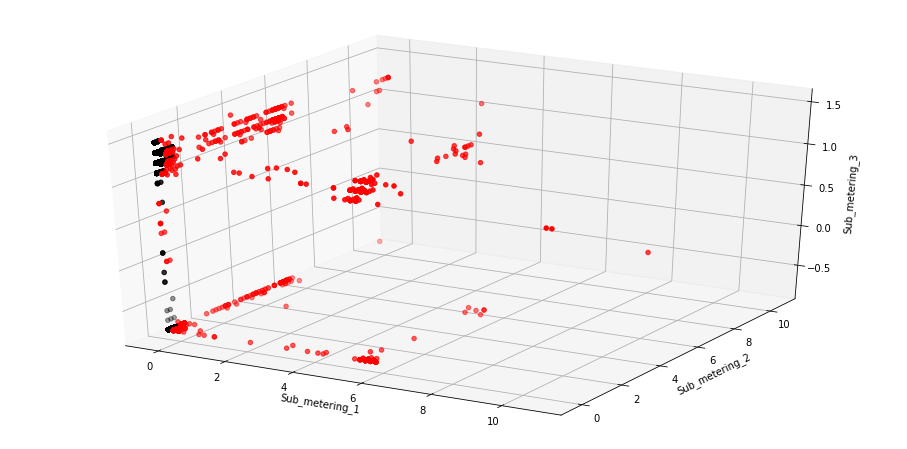

In [59]:
fig2 = plt.figure(figsize=(16, 8))
ax = fig2.add_subplot(111, projection='3d')

ax.scatter(
  xs = X[clusters>0,0],
  ys = X[clusters>0,1],
  zs = X[clusters>0,2],
  c = 'k',
)

ax.scatter(
  xs = X[clusters<0,0],
  ys = X[clusters<0,1],
  zs = X[clusters<0,2],
  c = 'r'
)
ax.set_xlabel('Sub_metering_1')
ax.set_ylabel('Sub_metering_2')
ax.set_zlabel('Sub_metering_3')

In [60]:
clusters_IF = clusters
print('There is',round(100*(np.sum(clusters==-1)/df_hc_skipna.shape[0]),1),'% of anomalous datimes, which are')
pd.DataFrame(df_hc_skipna.index[clusters==-1]).rename(columns={'datetime':'Anomaly date-time'})

There is 9.7 % of anomalous datimes, which are


,Anomaly date-time
0,2006-12-17 01:24:00
1,2006-12-17 01:54:00
2,2006-12-17 10:24:00
3,2006-12-17 10:54:00
4,2006-12-17 11:24:00
5,2006-12-17 16:24:00
6,2006-12-18 08:54:00
7,2006-12-18 19:24:00
8,2006-12-18 19:54:00
9,2006-12-18 22:54:00


## Anomaly detection using Local Outlier Factor

In [61]:
from sklearn.neighbors import LocalOutlierFactor

outlier_detection = LocalOutlierFactor(n_neighbors=20, algorithm='auto', leaf_size=30, metric='minkowski',
                                       p=2, metric_params=None, contamination='auto', novelty=False, n_jobs=None)
clusters = outlier_detection.fit_predict(X)

Text(0.5, 0, 'Sub_metering_3')

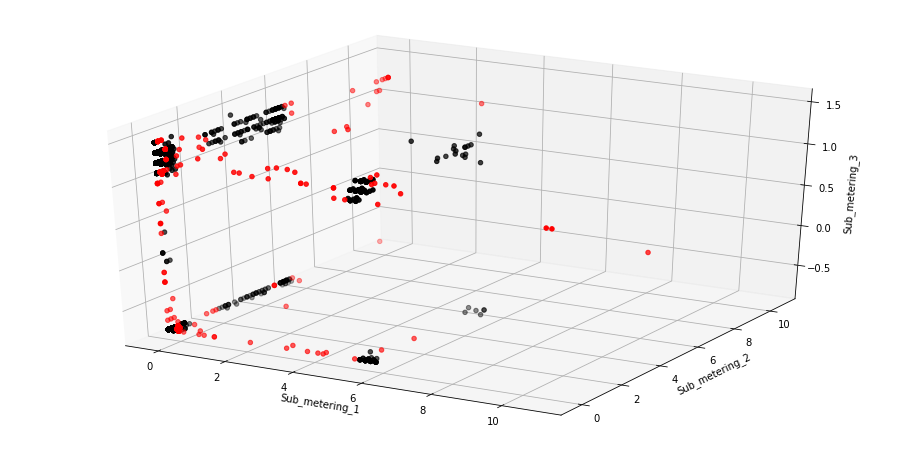

In [62]:
fig2 = plt.figure(figsize=(16, 8))
ax = fig2.add_subplot(111, projection='3d')

ax.scatter(
  xs = X[clusters>0,0],
  ys = X[clusters>0,1],
  zs = X[clusters>0,2],
  c = 'k',
)

ax.scatter(
  xs = X[clusters<0,0],
  ys = X[clusters<0,1],
  zs = X[clusters<0,2],
  c = 'r'
)
ax.set_xlabel('Sub_metering_1')
ax.set_ylabel('Sub_metering_2')
ax.set_zlabel('Sub_metering_3')

In [63]:
clusters_LOF = clusters
print('There is',round(100*(np.sum(clusters==-1)/df_hc_skipna.shape[0]),1),'% of anomalous datetimes, which are')
pd.DataFrame(df_hc_skipna.index[clusters==-1]).rename(columns={'datetime':'Anomaly date-time'})

There is 2.9 % of anomalous datetimes, which are


,Anomaly date-time
0,2006-12-16 18:54:00
1,2006-12-18 08:54:00
2,2006-12-18 23:24:00
3,2006-12-19 00:54:00
4,2006-12-19 08:54:00
5,2006-12-19 09:24:00
6,2006-12-19 11:24:00
7,2006-12-19 15:54:00
8,2006-12-20 14:54:00
9,2006-12-22 11:54:00


## Summary

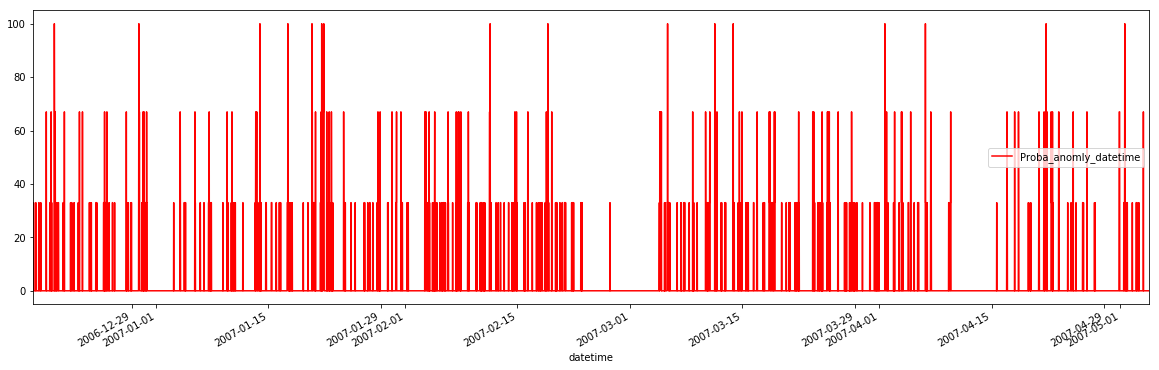

In [64]:

anomaly_detection = pd.DataFrame(np.asarray(clusters_dbscan==-1,dtype=int)+np.asarray(clusters_IF==-1,dtype=int)+np.asarray(clusters_LOF==-1,dtype=int),
                             index=df_hc_skipna.index,columns=['Proba_anomly_datetime'])
anomaly_detection['Proba_anomly_datetime'] = round(anomaly_detection['Proba_anomly_datetime']*(100/3),0)

anomaly_detection.plot(figsize=(20, 6),color='r')
plt.yl

In [345]:
anomaly_detection[anomaly_detection['Proba_anomly_datetime']>80]

,Proba_anomly_datetime
datetime,
2006-12-19 08:54:00,100.0
2006-12-29 21:24:00,100.0
2007-01-13 22:54:00,100.0
2007-01-17 10:24:00,100.0
2007-01-20 10:24:00,100.0
2007-01-21 15:24:00,100.0
2007-01-21 21:24:00,100.0
2007-01-21 21:54:00,100.0
2007-02-11 14:24:00,100.0
